# 연속형 변수 ---> 명목형 변수 추가

In [14]:
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd

In [15]:
origin = pd.read_excel('4사분위수_데이터.xlsx')
df = origin.drop('Unnamed: 0', axis=1)      # 콜론 뒤에 한 칸 띄어쓰기가 있는 경우 -> '~: 0'
df.head()

,price,carat,cut,color,clarity,x,y,z,depth,table
0,5324,1.21,Premium,H,SI2,6.75,6.78,4.24,62.7,59.0
1,5324,1.21,Very Good,H,SI2,6.70,6.75,4.21,62.6,61.0
2,5324,1.21,Very Good,I,SI1,6.76,6.92,4.25,62.1,56.0
3,5324,1.21,Ideal,J,VS1,6.81,6.86,4.26,62.3,55.0
4,5324,0.90,Very Good,F,VS1,6.18,6.23,3.80,61.2,56.0


In [16]:
# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.
    Parameters
    ---------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.
    Returns
    ------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
    # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p: (
            "//*" if p < 0.001 else
            "/*" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append({
            "종속변수": yname,                         # 종속변수 이름
            "독립변수": name,                          # 독립변수 이름
            "B": v[1].strip(),                        # 비표준화 회귀계수(B)
            "표준오차": v[2].strip(),                 # 계수 표준오차
            "Beta": float(fit.params[name]) * (data[name].std(ddof=1) /
        data[yname].std(ddof=1)),  # 표준화 회귀계수(β)
            "t": "%s%s" % (v[3].strip(), stars(p)), # t-통계량(+별표)
            "p-value": p,                             # 계수 유의확률
            "공차": 1 / vif,                          # 공차(Tolerance = 1/VIF)
            "vif": vif,                               # 분산팽창계수
        })
        
    rdf = DataFrame(variables)

    if rdf.empty:
        return None, "데이터 없음", "모델 유의하지 않음", []

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = f"𝑅({result_dict['R-squared']}),𝑅^2({result_dict['Adj. R-squared']}), 𝐹({result_dict['F-statistic']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})"

    # 모형 보고 문장 구성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl %(
        rdf['종속변수'][0],
        ",".join(list(rdf['독립변수'])),
        "유의하다" if float(result_dict['Prob (F-statistic)']) <= 0.05 else "유의하지 않다",
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        "<=" if float(result_dict['Prob (F-statistic)']) <= 0.05 else ">"
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(s % (row['독립변수'],
                row['B'],
                "<=" if float(row['p-value']) < 0.05 else '>',
                row['종속변수'],
                '유의미한' if float(row['p-value']) < 0.05 else '유의하지 않은'))
        
    return rdf, result_report, model_report, variable_reports


In [21]:
df2=df.copy()
yname ='price'

df2 =df.drop(['cut','color','clarity'], axis=1)     #명목형 변수 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(' === 1차 회귀분석 ===')
display(rdf)
print(m)

 === 1차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,6534.7055,224.693,0.695787,29.083//*,0.000,0.006546,152.768361
1,price,x,126.3534,168.238,0.022079,0.751,0.453,0.000610,1639.245437
2,price,y,44.6804,48.735,0.009439,0.917,0.359,0.003623,276.007658
3,price,z,296.3369,175.686,0.033195,1.687,0.092,0.000838,1193.124153
4,price,depth,-251.1899,21.245,-0.099486,-11.824//*,0.000,0.001242,805.118141
5,price,table,-142.9256,10.437,-0.083606,-13.694//*,0.000,0.001654,604.420627


price에 대하여 carat,x,y,z,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,13450) = 2862., p <= 0.05).


In [22]:
df2=df.copy()
yname ='price'

df2 =df.drop(['x','cut','color','clarity'], axis=1)     #명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(' === 2차 회귀분석 ===')
display(rdf)
print(m)

 === 2차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,6662.4570,146.807,0.709389,45.382//*,0.000,0.009637,103.767927
1,price,y,48.5994,48.454,0.010267,1.003,0.316,0.003986,250.894729
2,price,z,365.8426,149.332,0.040981,2.450*,0.014,0.000997,1003.163709
3,price,depth,-260.9470,16.809,-0.103350,-15.524//*,0.000,0.001250,799.805739
4,price,table,-143.4791,10.411,-0.083930,-13.782//*,0.000,0.002239,446.617489


price에 대하여 carat,y,z,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,13451) = 3434., p <= 0.05).


In [24]:
df2=df.copy()
yname ='price'

df2 =df.drop(['z','x','cut','color','clarity'], axis=1)     #명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(' === 3차 회귀분석 ===')
display(rdf)
print(m)

 === 3차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,6947.0659,89.772,0.739693,77.385//*,0.00,0.027471,36.401586
1,price,y,92.3450,45.053,0.019509,2.050*,0.04,0.004696,212.937818
2,price,depth,-245.1384,15.524,-0.097089,-15.791//*,0.00,0.002309,433.017002
3,price,table,-144.9784,10.395,-0.084807,-13.947//*,0.00,0.002253,443.884475


price에 대하여 carat,y,depth,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,13452) = 4289., p <= 0.05).


In [26]:
df2=df.copy()
yname ='price'

df2 =df.drop(['table','z','x','cut','color','clarity'], axis=1)     #명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(' === 4차 회귀분석 ===')
display(rdf)
print(m)

 === 4차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,6772.7562,89.535,0.721134,75.643//*,0.000,0.027762,36.019977
1,price,y,131.4629,45.287,0.027773,2.903/*,0.004,0.004996,200.145477
2,price,depth,-176.3257,14.825,-0.069835,-11.894//*,0.000,0.009437,105.968637


price에 대하여 carat,y,depth로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,13453) = 5574., p <= 0.05).


In [28]:
df2=df.copy()
yname ='price'

df2 =df.drop(['y','table','z','x','cut','color','clarity'], axis=1)     #명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df2)

print(' === 5차 회귀분석 ===')
display(rdf)
print(m)

 === 5차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,6979.8556,54.114,0.743185,128.984//*,0.0,0.069575,14.372957
1,price,depth,-184.6658,14.548,-0.073138,-12.694//*,0.0,0.069575,14.372957


price에 대하여 carat,depth로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(2,13454) = 8352., p <= 0.05).


In [29]:
df2=df.copy()
yname ='price'

df2 =df.filter(['price','carat'])     #명목형 변수 제외 + vif_max 제외
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

# rdf, r, m, v = ols_report(tbl1, df2)

print(' === 6차 회귀분석 ===')
display(tbl1)
print(m)

 === 6차 회귀분석 ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                 1.635e+04
Date:                Tue, 13 Jan 2026   Prob (F-statistic):               0.00
Time:                        19:09:19   Log-Likelihood:            -1.2415e+05
No. Observations:               13457   AIC:                         2.483e+05
Df Residuals:                   13455   BIC:                         2.483e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -222.7117     80.348     -2.772      0.006    -380.205     -65.218
carat       6955.9302     54.402    127.861      0.000    6849.294    7062.566
==============================================================================
Omnibus:                      709.919   Durbin-Watson:                   0.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1681.086
Skew:                           0.325   Prob(JB):                         0.00
Kurtosis:                       4.605   Cond. No.                         8.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

price에 대하여 carat,depth로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(2,13454) = 8352., p <= 0.05).


In [36]:
df2=df.copy()
yname ='price'

df2 =df.filter(['price','carat','cut','color','clarity'])     #명목형 변수 추가
df3=pd.get_dummies(df2, drop_first=True).astype(float)
x=df3.drop(yname, axis=1)
y = df3[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()

rdf, r, m, v = ols_report(tbl1, df3)
print(' === 7차 회귀분석 ===')
display(rdf)
print(m)

 === 7차 회귀분석 ===


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,price,carat,1.117e+04,40.554,1.189543,275.483//*,0.0,0.057077,17.520262
1,price,cut_Good,1004.8032,83.236,0.075912,12.072//*,0.0,0.279606,3.576467
2,price,cut_Ideal,1763.7065,75.581,0.228817,23.335//*,0.0,0.084613,11.818465
3,price,cut_Premium,1274.7875,75.297,0.162579,16.930//*,0.0,0.090025,11.108048
4,price,cut_Very Good,1403.3683,76.804,0.160657,18.272//*,0.0,0.122706,8.149592
5,price,color_E,-322.7884,54.106,-0.028200,-5.966//*,0.0,0.440082,2.272305
6,price,color_F,-641.9237,51.381,-0.063826,-12.494//*,0.0,0.358822,2.786900
7,price,color_G,-1475.9936,48.880,-0.171493,-30.196//*,0.0,0.261349,3.826301
8,price,color_H,-2487.3536,50.689,-0.265239,-49.071//*,0.0,0.303239,3.297733
9,price,color_I,-3504.3194,54.940,-0.332496,-63.785//*,0.0,0.339373,2.946608


price에 대하여 carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,13438) = 4444., p <= 0.05).


In [37]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 190.1232
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


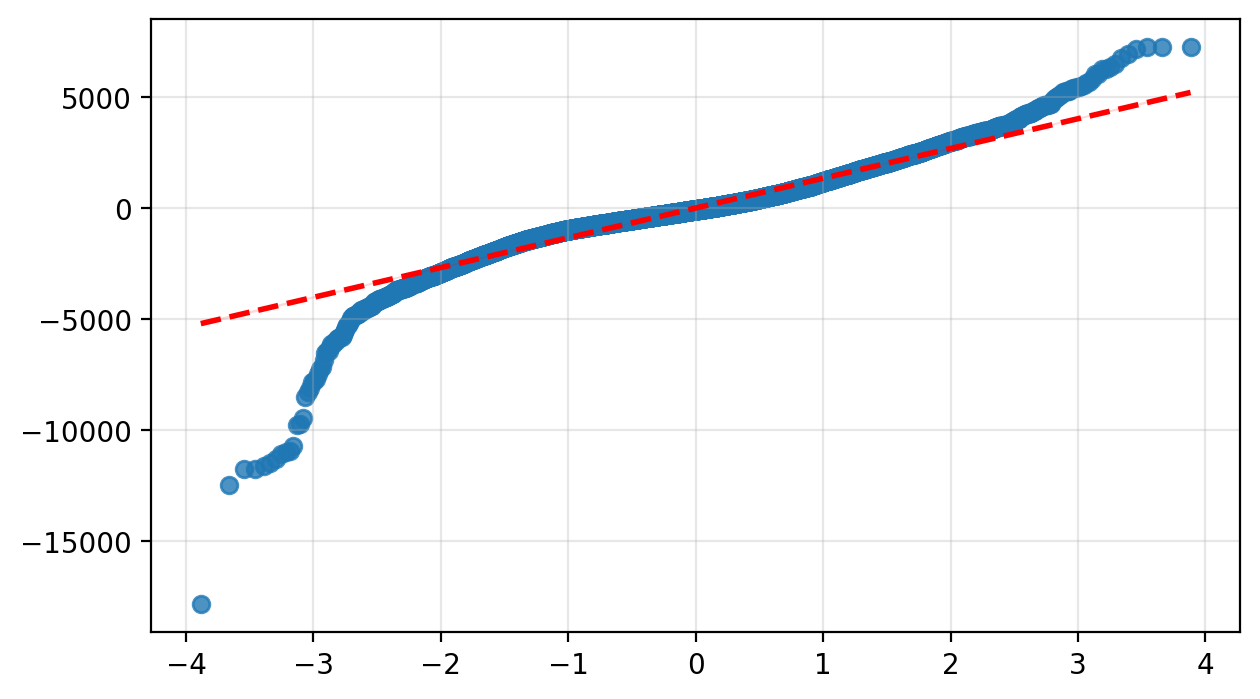

In [38]:
(x, y), _ = probplot(fit.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(x=x, y=y, line_kws={
    "color": "red",
    "linestyle": "--",   
    "linewidth": 2
            })

ax.grid(True, alpha=0.3)   

plt.tight_layout()      
plt.show()              
plt.close()             
